# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, an alternation of strategy steps description and its corresponding code cells is depicted for the process of **Building a traffic sign recognition classfifier**. 
The steps are:
- Load data
- Summarize and explore data
- Design and test a model architecture
- Train, validate and test the model
- Test the model with images not present in the training data steps
- Analize the performance of the classifier 

All the necessary code is presented along this notebook and [here](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip) you can find the training data set. 

> **Note**: Once the code implementations were done, an export of this iPython Notebook as an HTML document was done for review purposes.

---
## Step 0: Load The Data

In [3]:
import pickle

traffic_signs_data_folder = 'traffic-signs-data/'
training_file = traffic_signs_data_folder + 'train.p'
validation_file= traffic_signs_data_folder + 'valid.p'
testing_file = traffic_signs_data_folder + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print ('Training data loaded succesfully!!!  [from German Traffic Signs Data Base]')

Training data loaded succesfully!!!  [from German Traffic Signs Data Base]


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

 ### 1.1 Data Summary

In [4]:
import pandas as pd
import numpy as np

assert (len(X_train) == len(y_train))
assert (len(X_valid) == len(y_valid))
assert (len(X_test)  == len(y_test))

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# shape of an traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Size of training set: ", n_train)
print("Size of the validation set: ", n_validation)
print("Size of test set: ", n_test)
print("Shape of a traffic sign image:", image_shape)
print("Number of unique classes/labels in the data set:", n_classes)

Size of training set:  34799
Size of the validation set:  4410
Size of test set:  12630
Shape of a traffic sign image: (32, 32, 3)
Number of unique classes/labels in the data set: 43


### 1.2 Exploratory visualization of the dataset
Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** Take into account the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Visualization of image in the data set (index: 328)


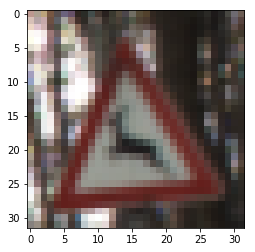

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
for index in range(328,329):
    image = X_train[index]
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    print("Visualization of image in the data set (index: 328)")

In [6]:

# read the semantics of the numbers
import csv
import random
# Visualizations of the images and its corresponding labes shown in the notebook.
%matplotlib inline

classId2SignName = {}

with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        classId2SignName[row[0]] = row[1]
            
def visualizeDataSet(images,labels):
    n_columns = 6
    n_rows = int(len(images)/n_columns)+1
    width = 24
    height = n_rows * 3
    fig, axs = plt.subplots(n_rows,n_columns, figsize=(width, height))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axs = axs.ravel()
    for i in range(n_columns * n_rows):
        axs[i].axis('off')
        if (i<len(images)):
            image = images[i]
            axs[i].axis('off')
            axs[i].imshow(image)
            axs[i].set_title('{} ({:.20})'.format(labels[i], classId2SignName[str(labels[i])]))

Visualization of the data set images and labels:


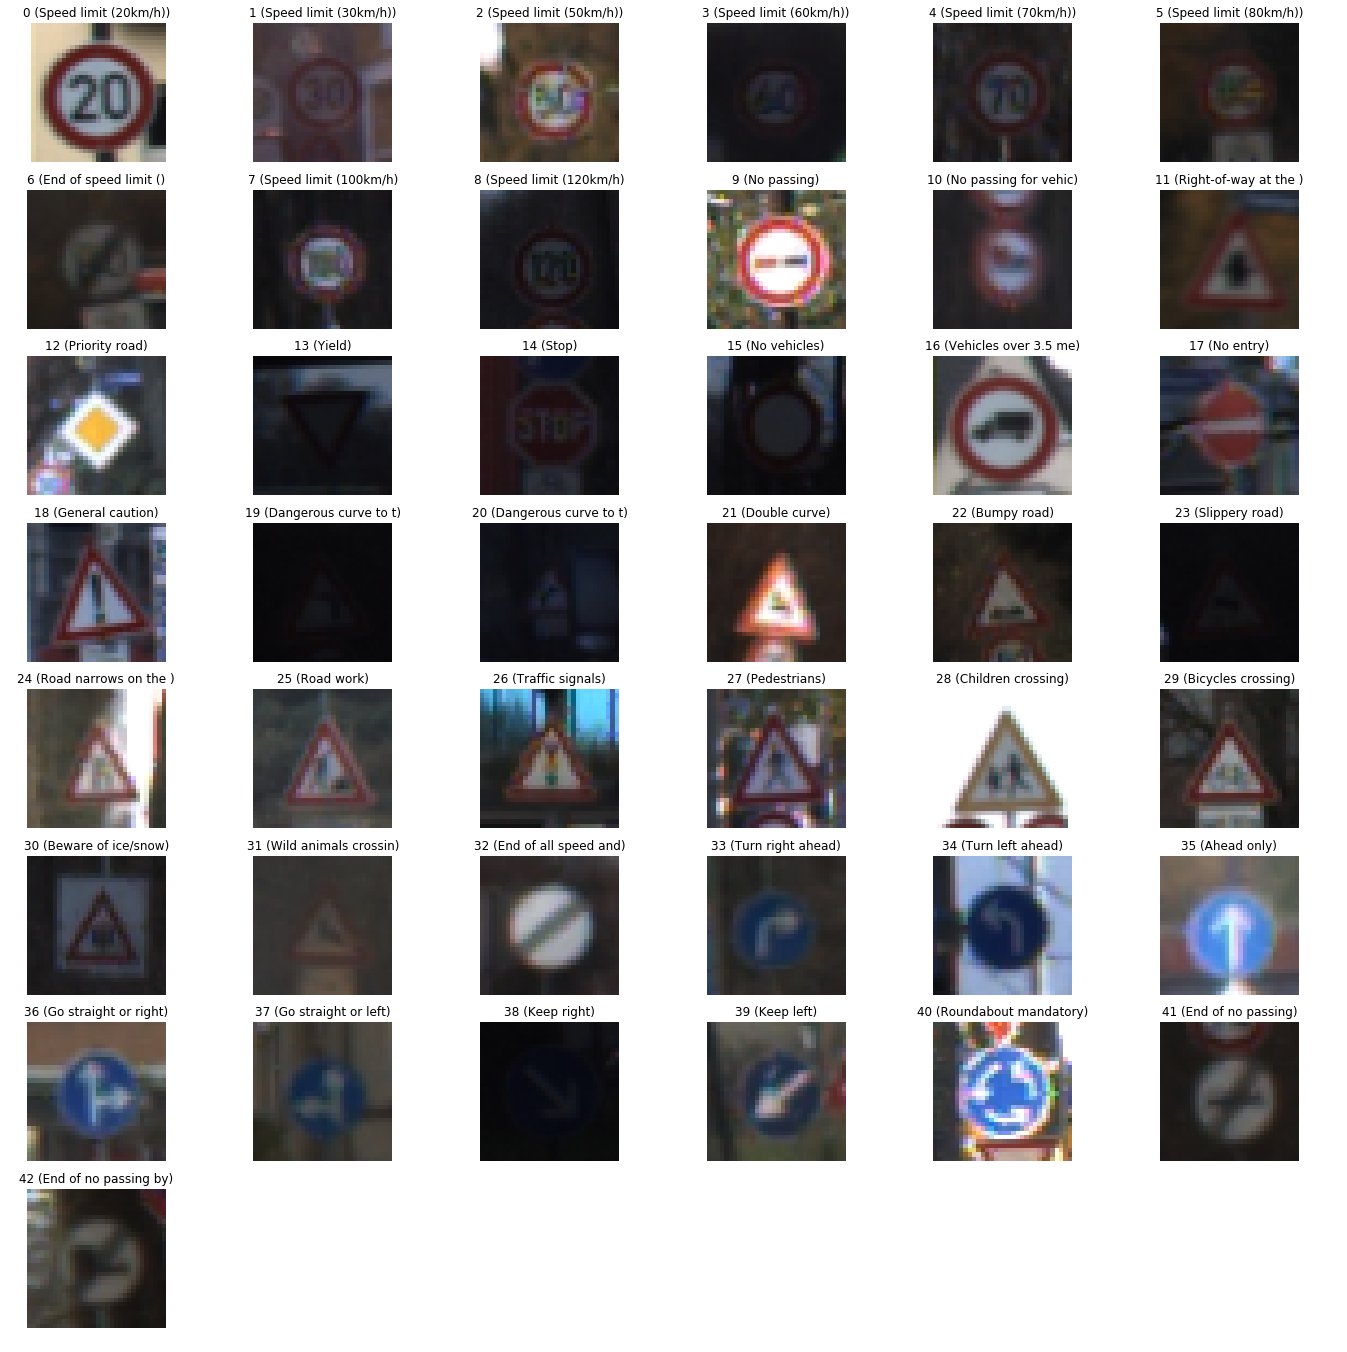

In [7]:

X = []
Y = []

labels, indices = np.unique(y_train, return_index=True)
for i in range(len(labels)):
    X.append(X_train[indices[i]])
    Y.append(labels[i])
        
visualizeDataSet(X,Y)

print ('Visualization of the data set images and labels:')

### 1.3. Distribution of classes

Distribution of samples per label - Barplot


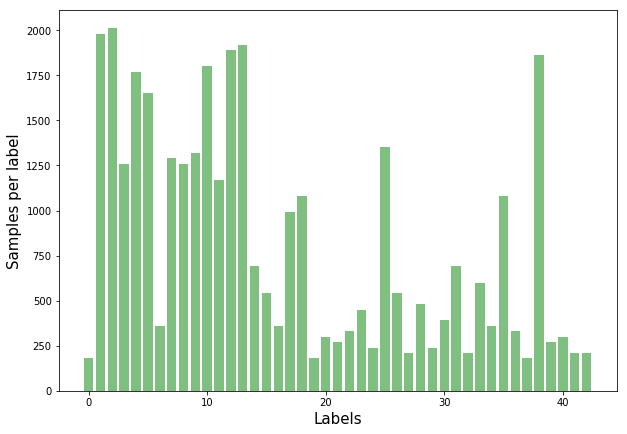

In [8]:
bar_width = 0.35
x,y = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10,7))
plt.bar(x,y, align='center', color='g', alpha=0.5)
plt.ylabel('Samples per label', fontsize=15)
plt.xlabel('Labels', fontsize=15)
plt.show

print ('Distribution of samples per label - Barplot')

----

## Step 2: Design and Test a Model Architecture

Design and implementation of a deep learning model that learns to recognize traffic signs. 
Training and testing the model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### 2.1. Preprocessing

In [9]:
def preProcess(color_images):
    # grayscale
    grayscaled_images = np.sum(color_images/3, axis=3, keepdims=True)
    
    # normalize (PIXEL-128)/128
    normalized_images = (grayscaled_images - 128) / 128
    
    
    return normalized_images

print ('Grayscalation and normalization succesfully done!!')

Grayscalation and normalization succesfully done!!


Original Random Image
GrayScaled Random Image


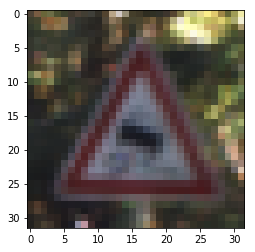

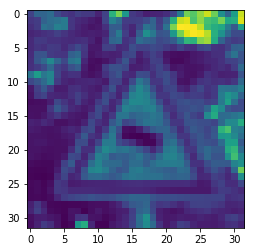

In [10]:
import cv2
def getRandomImage(x, y, filter_index):
    indices, = np.nonzero( y==filter_index )
    index = np.random.choice(indices)
    return x[index]
    

image = getRandomImage(X_train, y_train, 23)
plt.figure(figsize=(4,4))
plt.imshow(image)

print ('Original Random Image')

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(4,4))
plt.imshow(gray_image)

print ('GrayScaled Random Image')

In [11]:
print (X_train.shape)
preprocessed = preProcess(X_train)
print (preprocessed.shape)

print ('Preprocessing done successfully!')

(34799, 32, 32, 3)
(34799, 32, 32, 1)
Preprocessing done successfully!


### 2.2. Model Architecture

In [12]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [21]:
import tensorflow as tf

EPOCHS = 50 # tried with 150 (overtraining)
BATCH_SIZE = 128
DROPOUT = 0.5

print(tf.__version__)

1.3.0


In [22]:
keep_prob = tf.placeholder(tf.float32)               # in v2.0 tf.placeholder() is available as tf.compat.v1.placeholder() in v2
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

In [23]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # **================**
    # ** --- Layer 1 ---** 
    # **================**
    # 1.1 Convolutional: 
    #     Input = 32x32x1. Output = 28x28x6.   
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # 1.2 Activation.
    conv1 = tf.nn.relu(conv1)

    # 1.3 Pooling:
    #     Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # **================**
    # ** --- Layer 2 ---** 
    # **================**
    # 2.1 Convolutional. 
    #     Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # 2.2 Activation.
    conv2 = tf.nn.relu(conv2)

    # 2.3 Pooling. 
    #     Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 2.4 Flatten. 
    #     Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)  # in v2.0 flatten() is  tf.compat.v1.layers.flatten()    
    
    # **================**
    # ** --- Layer 3 ---** 
    # **================**
    # 3.1 Fully Connected. 
    #     Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # 3.2 Activation.
    fc1    = tf.nn.relu(fc1)

    # **================**
    # ** --- Layer 4 ---** 
    # **================**
    # 4.1 Fully Connected.
    #     Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # 4.2 Activation.
    fc2    = tf.nn.relu(fc2)

    # **================**
    # ** --- Layer 5 ---** 
    # **================**
    
    # 5.1 Fully Connected.
    #     Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))


    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [86]:
from tensorflow.contrib.layers import flatten

def LeNetKeepProb(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # **================**
    # ** --- Layer 1 ---** 
    # **================**    
    # 1.1 Convolutional. 
    #     Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # 1.2 Activation.
    conv1 = tf.nn.relu(conv1)

    # 1.3 Pooling. 
    #     Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # **================**
    # ** --- Layer 2 ---** 
    # **================**
    # 2.2 Convolutional. 
    #     Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # 2.2 Activation.
    conv2 = tf.nn.relu(conv2)

    # 2.3 Pooling. 
    #     Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 2.4 Flatten. 
    #     Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)  # in v2.0 flatten() is  tf.compat.v1.layers.flatten()
    fc0   = tf.nn.dropout(fc0, keep_prob)

    # **================**
    # ** --- Layer 3 ---** 
    # **================**    
    # 3.1 Fully Connected. 
    #     Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # 3.2 Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob) 

    # **================**
    # ** --- Layer 4 ---** 
    # **================**
    # 4.1 Fully Connected. 
    #     Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # 4.2 Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob) 

    # **================**
    # ** --- Layer 5 ---** 
    # **================**    
    # 5.1 Fully Connected. 
    #     Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))


    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### 2. 3 Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [87]:
rate = 0.0006

logits = LeNetKeepProb(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [88]:

X_train_preProcessed = preProcess(X_train)
X_valid_preProcessed = preProcess(X_valid)
X_test_preProcessed  = preProcess(X_test)

Training...

EPOCH 1 ...
Training Accuracy = 0.200
Validation Accuracy = 0.157

EPOCH 2 ...
Training Accuracy = 0.557
Validation Accuracy = 0.513

EPOCH 3 ...
Training Accuracy = 0.694
Validation Accuracy = 0.634

EPOCH 4 ...
Training Accuracy = 0.771
Validation Accuracy = 0.728

EPOCH 5 ...
Training Accuracy = 0.836
Validation Accuracy = 0.781

EPOCH 6 ...
Training Accuracy = 0.863
Validation Accuracy = 0.811

EPOCH 7 ...
Training Accuracy = 0.882
Validation Accuracy = 0.819

EPOCH 8 ...
Training Accuracy = 0.896
Validation Accuracy = 0.832

EPOCH 9 ...
Training Accuracy = 0.908
Validation Accuracy = 0.846

EPOCH 10 ...
Training Accuracy = 0.916
Validation Accuracy = 0.856

EPOCH 11 ...
Training Accuracy = 0.919
Validation Accuracy = 0.857

EPOCH 12 ...
Training Accuracy = 0.928
Validation Accuracy = 0.870

EPOCH 13 ...
Training Accuracy = 0.928
Validation Accuracy = 0.864

EPOCH 14 ...
Training Accuracy = 0.936
Validation Accuracy = 0.877

EPOCH 15 ...
Training Accuracy = 0.942
Valid

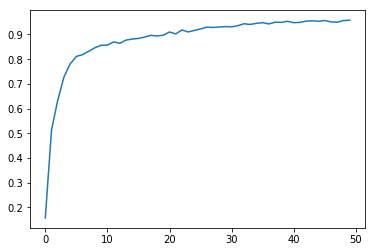

In [89]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    validation_accuracies = []
    
    for i in range(EPOCHS):
        X_train, X_train_preProcessed, y_train = shuffle(X_train, X_train_preProcessed, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_preProcessed[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
            
        training_accuracy = evaluate(X_train_preProcessed, y_train)
        validation_accuracy = evaluate(X_valid_preProcessed, y_valid)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        validation_accuracies.append(validation_accuracy)
        
    saver.save(sess, './lenet')
    
    # Show Learning Statistics
    plt.plot(range(EPOCHS),validation_accuracies)
    plt.show
    
    print("Model saved")

In [90]:

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    train_accuracy = evaluate(X_test_preProcessed, y_test)
    print("Train Accuracy = {:.3f}".format(train_accuracy))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    valid_accuracy = evaluate(X_valid_preProcessed, y_valid)
    print("Validation Accuracy = {:.3f}".format(valid_accuracy))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_preProcessed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Train Accuracy = 0.947
INFO:tensorflow:Restoring parameters from ./lenet
Validation Accuracy = 0.958
INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.947


---

## Step 3: Test a Model on New Images

To have a better insight into how the model is working. The model is to be tested with the 10 images to be found in the folder 'test_images/' downloaded from the German traffic signs from the web. The model depicted above is used to predict the traffic sign type.
The `signnames.csv` is being used to determine the mappings from the class id (integer) to the actual sign name.

### 3.1 Load and Output the Images

Test images loaded with corresponding labesl


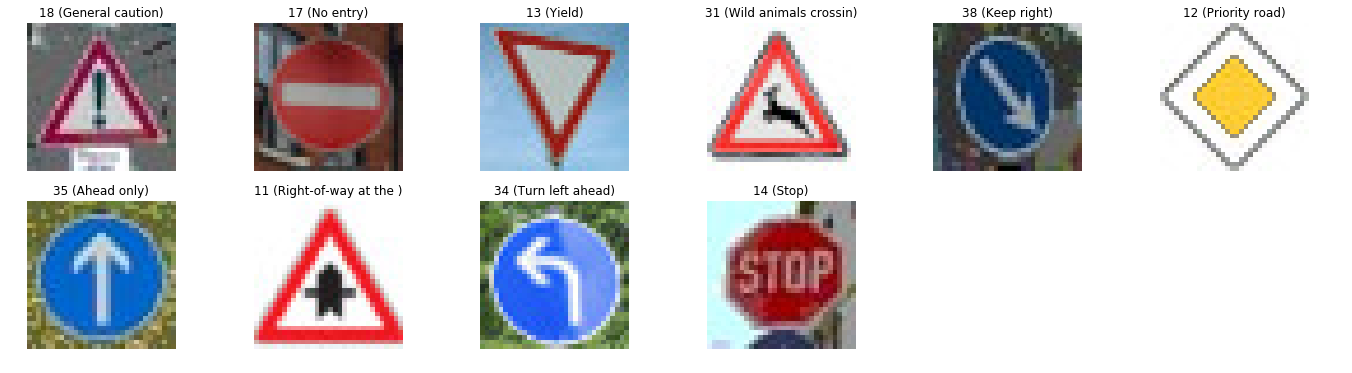

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

traffic_signs_data_folder = 'test_images/'
    
test_model_for_X = []
test_model_for_Y = []

for image_file in glob.glob(traffic_signs_data_folder + "*.jpg"):
    image = np.array(mpimg.imread(image_file))
    try:
    #if (True):
        # the label is encoded into the first two characters of the file names
        label_str = image_file[len(traffic_signs_data_folder):][:2]
        label = int(label_str)
        test_model_for_X.append(image)
        test_model_for_Y.append(label)
    except  Exception:
        print ('Image not loaded {}'.format(image_file))
        
visualizeDataSet(test_model_for_X, test_model_for_Y)

print ('Test images loaded with corresponding labesl')


### 3.2 Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./lenet
[18 17 13 31 38 12 35 11 34 14]


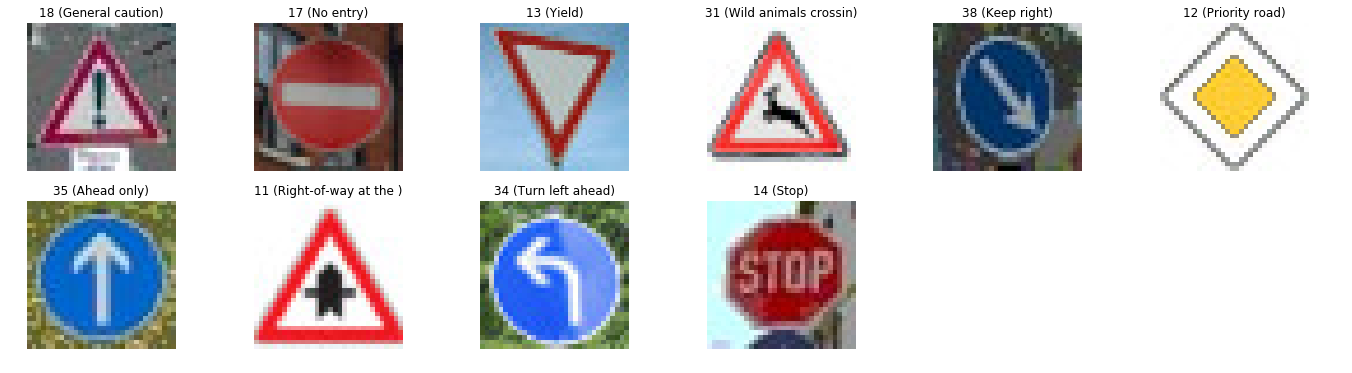

In [92]:
test_model_for_X_preProcessed = preProcess(np.array(test_model_for_X))

prediction=tf.argmax(logits,1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: test_model_for_X_preProcessed, keep_prob: 1.0})
    visualizeDataSet(test_model_for_X, predictions)
    
    print (predictions)

### 3.3 Analyze Performance

In [93]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(test_model_for_X_preProcessed, test_model_for_Y)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [368]:
def visualizeTopFiveOperations(test_images, train_images, top_k):
    probabilities = top_k.values
    indices = top_k.indices
    assert (len(test_images) == len(indices))
          
    n_columns = 6
    n_rows = len(indices)
    width = 24
    height = n_rows * 3
    fig, axs = plt.subplots(n_rows,n_columns, figsize=(width, height))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axs = axs.ravel()
    i = 0
    for row in range(n_rows):
        axs[i].axis('off')
        axs[i].imshow(test_images[row])
        i += 1
        for j in range(len(indices[row])):
            index = indices[row][j]
            probability = probabilities[row][j]
            axs[i].axis('off')
            axs[i].set_title('{:.2f}% ({} {:.20})'.format(probability*100, index,  classId2SignName[str(index)]))
            axs[i].imshow(getRandomImage(X_train, y_train, index))
            i += 1

In [369]:
import numpy as np
def visualizeTopFiveProbabilities(test_images, train_images, top_k):
    probabilities = top_k.values
    indices = top_k.indices
    assert (len(test_images) == len(indices))
          
    n_columns = 2
    n_rows = len(indices)
    width = 24
    height = n_rows * 3
    fig, axs = plt.subplots(n_rows,n_columns, figsize=(width, height))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axs = axs.ravel()
    i = 0
    for row in range(n_rows):
        axs[i].axis('off')
        axs[i].imshow(test_images[row])
        i += 1
        labs=[classId2SignName[str(j)] for j in indices[row]]
        axs[i].barh([1, 2, 3, 4, 5],probabilities[row]*100, log=True)
 
        axs[i].set_yticklabels(labs)
        #axs[i].set_xticklabels(labs, visible=False)
        i += 1

INFO:tensorflow:Restoring parameters from ./lenet
Find each image with its probability(next to the image and in a logaritmic scale plot)


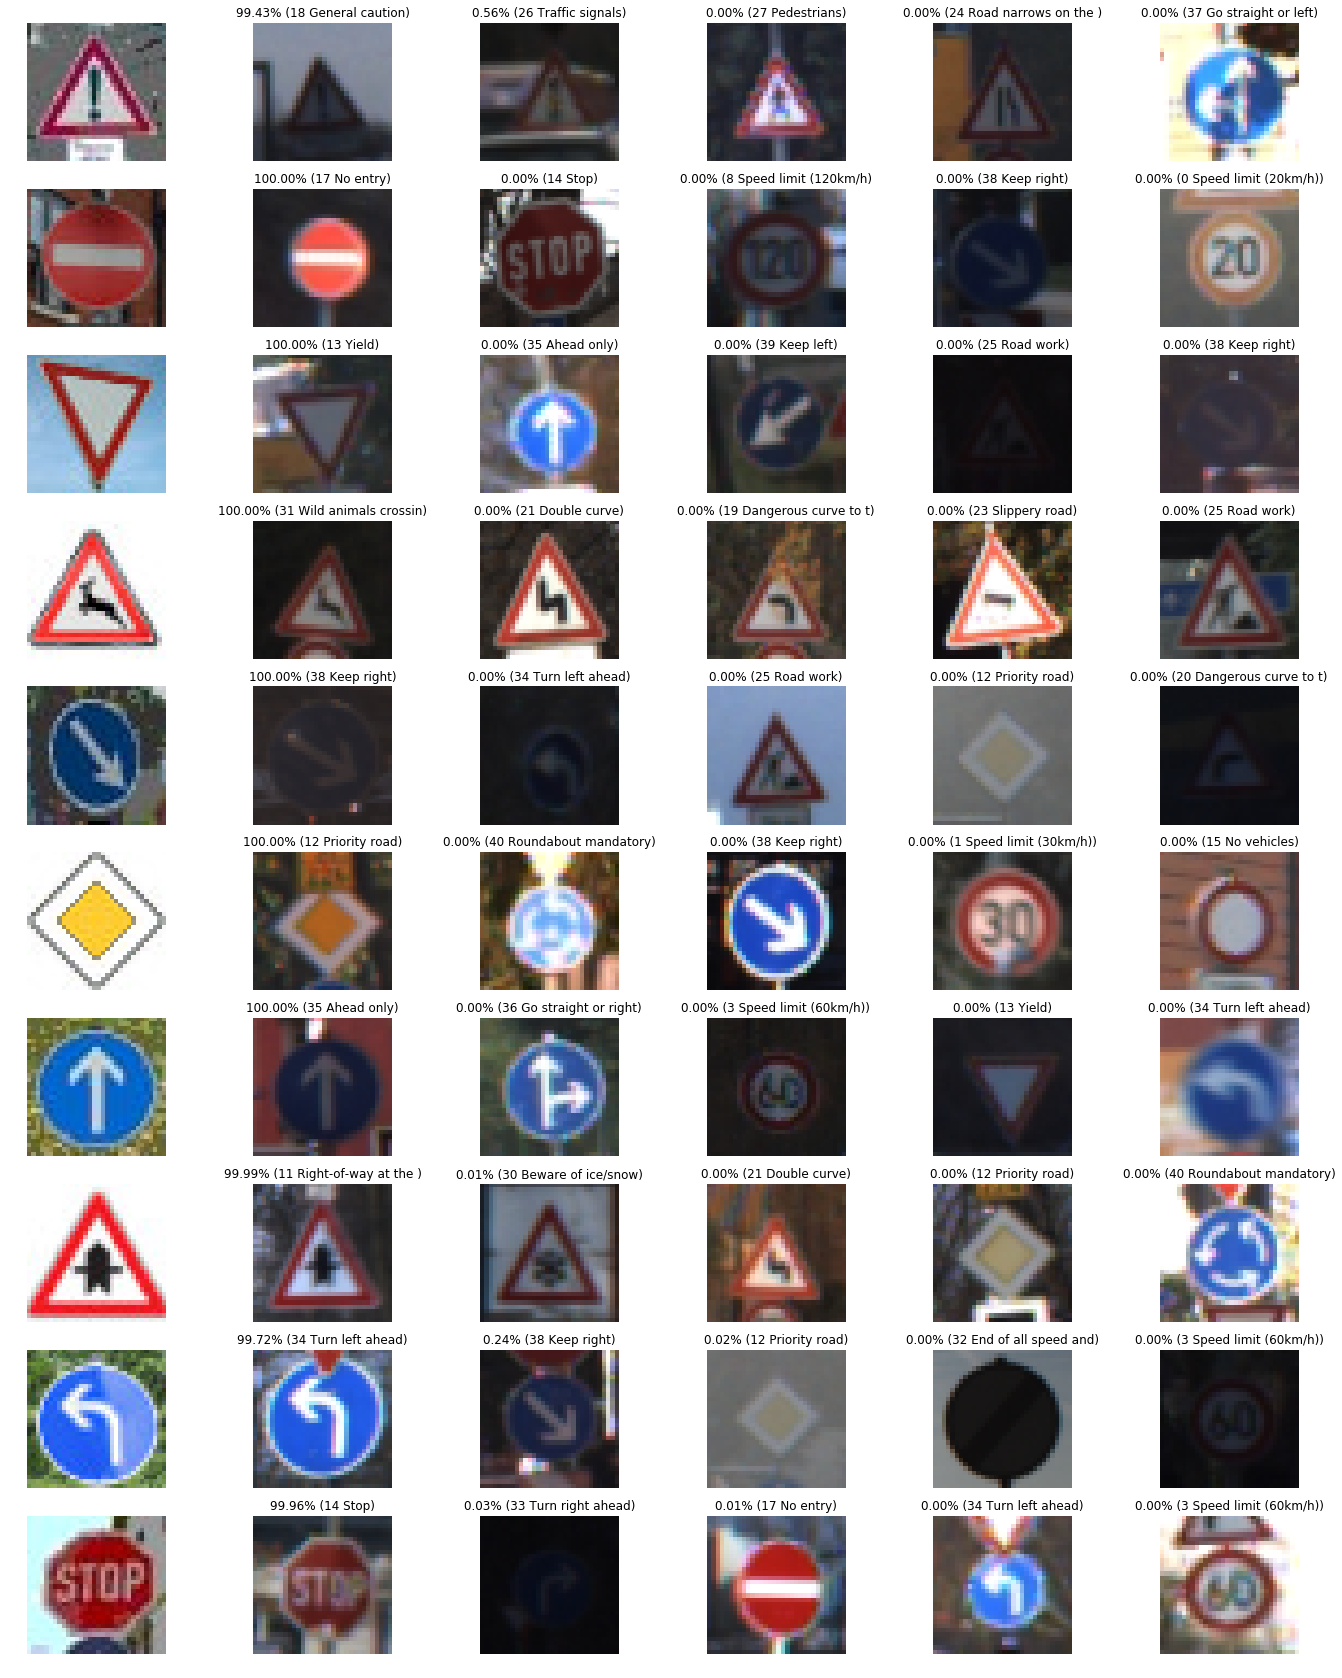

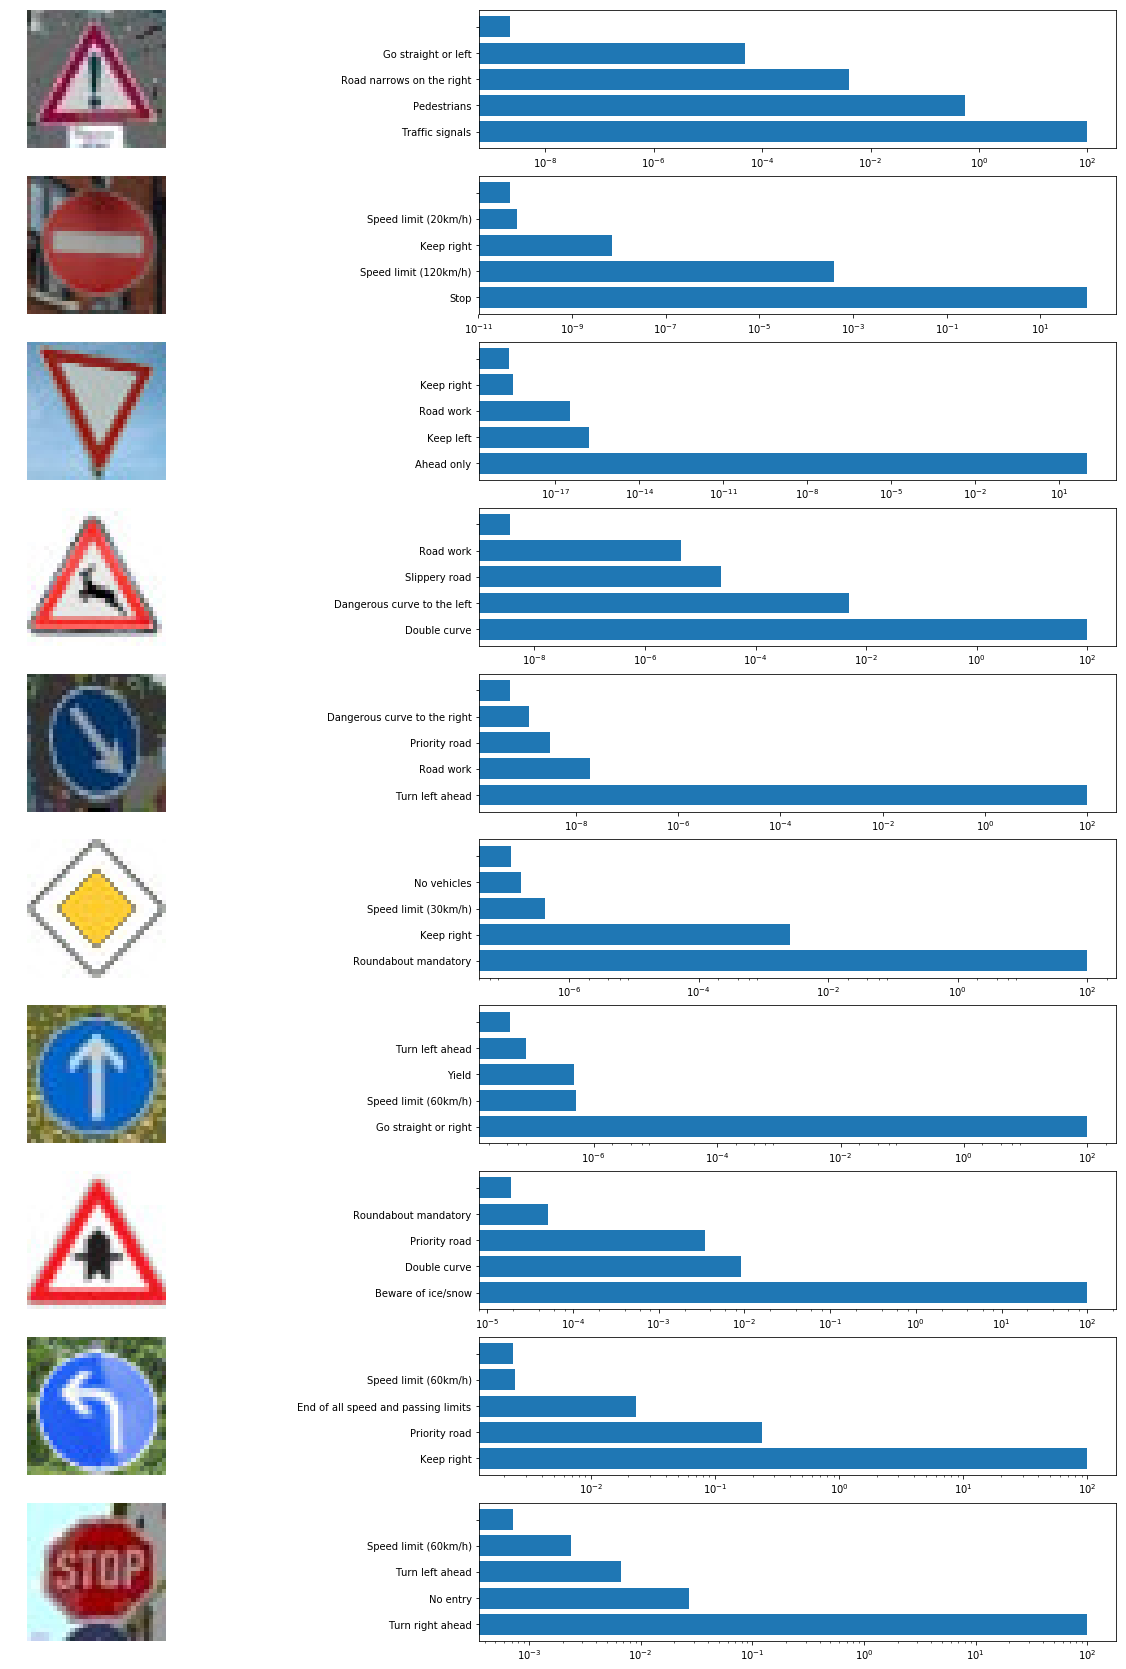

In [371]:
softmax_logits = tf.nn.softmax(logits)
top_k=tf.nn.top_k(softmax_logits,5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k = sess.run(top_k, feed_dict={x: test_model_for_X_preProcessed, keep_prob : 1.0})
    
    visualizeTopFiveOperations(test_model_for_X, X_train, top_k)
    visualizeTopFiveProbabilities(test_model_for_X, X_train, top_k)
    
print('Find each image with its probability(next to the image and in a logaritmic scale plot)')

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.